* https://innovation.alteryx.com/prediction-engineering-churn/
* https://www.kdnuggets.com/2019/05/churn-prediction-machine-learning.html
* https://www.datarobot.com/blog/predicting-churn-how-data-can-help-with-customer-retention/
* https://medium.com/analytics-vidhya/how-to-predict-which-customers-would-churn-based-on-transactional-data-da1c48836e3d

The optional THRESHOLD parameter can be used to modify the default classification threshold of 0.5. For more information on these metrics, you can read through the definitions on precision and recall, accuracy, f1-score, log_loss and roc_auc. Comparing the resulting evaluation metrics can help to decide among multiple models.

Furthermore, we used a confusion matrix to inspect how well the model predicted the labels, compared to the actual labels. The confusion matrix is created using the default threshold of 0.5, which you may want to adjust to optimize for recall, precision, or a balance (more information here).

roc_curve/precision-recall

In [1]:
import os

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn import set_config
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from src.config import CATEGORICAL_COL, NUMERICAL_COL, LABEL_COL
from src.utils import plot_metric_curves
from src.transformer import preprocessor_numeric, preprocessor_full

set_config(display='diagram')   

# Load Dataset

In [2]:
train = pd.read_csv('../data/users_train.csv')
val = pd.read_csv('../data/users_val.csv')

train.drop(columns=['user_first_engagement','user_pseudo_id'], inplace=True)
val.drop(columns=['user_first_engagement','user_pseudo_id'], inplace=True)

In [3]:
x_train, y_train = train.drop(columns=[LABEL_COL]), train[LABEL_COL]
x_val, y_val = val.drop(columns=[LABEL_COL]), val[LABEL_COL]

# Modeling

## Only numeric features
### Tranformer

### Linear model

In [4]:
linear_model = Pipeline(
    steps=[
        ("preprocessor", preprocessor_numeric()),
        ("linear_regressor", LogisticRegression(class_weight="balanced")),
    ]
)
linear_model.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['cnt_user_engagement',
                                                   'cnt_level_start_quickplay',
                                                   'cnt_level_end_quickplay',
                                                   'cnt_level_complete_quickplay',
                                                   'cnt_level_reset_quickplay',
                                                   'cnt_post_score',
                                                   'cnt_spend_virtual_currency',
                                                   'cnt_ad_reward',
                                                   'cnt_challenge_a_friend',
                                                   'cnt_completed_5_levels',
                                                   'cnt_use_extra_steps']),
                                                 ('drop', 'drop',
                                                  ['country_name', 'device_os',
                                                   'device_lang'])])),
                ('linear_regressor',
                 LogisticRegression(class_weight='balanced'))])

### Evaluation

              precision    recall  f1-score   support

           0       0.82      0.80      0.81       564
           1       0.33      0.35      0.34       155

    accuracy                           0.71       719
   macro avg       0.57      0.58      0.58       719
weighted avg       0.71      0.71      0.71       719



None

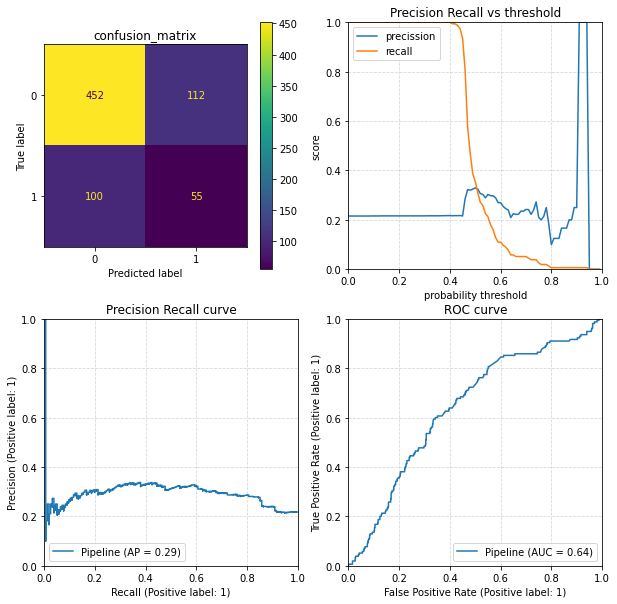

In [5]:
y_val_pred = linear_model.predict(x_val)

display(print(metrics.classification_report(y_val, y_val_pred)))

ax = plot_metric_curves(linear_model, x_val, y_val)

## Numerical and Categorical features

### Modeling

In [6]:
linear_model_full = Pipeline(
    steps=[
        ("preprocessor", preprocessor_full()),
        ("linear_regressor", LogisticRegression(class_weight="balanced")),
    ]
)
linear_model_full.fit(x_train, y_train)

/home/creyesp/Projects/ml-workshop-campus-party/venv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['cnt_user_engagement',
                                                   'cnt_level_start_quickplay',
                                                   'cnt_level_end_quickplay',
                                                   'cnt_level_complete_quickplay',
                                                   'cnt_level_reset_quickplay',
                                                   'cnt_post_score',
                                                   'cnt_spend_virtual_currency',
                                                   'cnt_ad_reward',
                                                   'cnt_challenge_a_friend',
                                                   'cnt_completed_5_levels',
                                                   'cnt_use_extra_steps']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['country_name', 'device_os',
                                                   'device_lang'])])),
                ('linear_regressor',
                 LogisticRegression(class_weight='balanced'))])

### Evaluation

              precision    recall  f1-score   support

           0       0.81      0.73      0.77       564
           1       0.28      0.38      0.32       155

    accuracy                           0.66       719
   macro avg       0.55      0.56      0.55       719
weighted avg       0.70      0.66      0.67       719



None

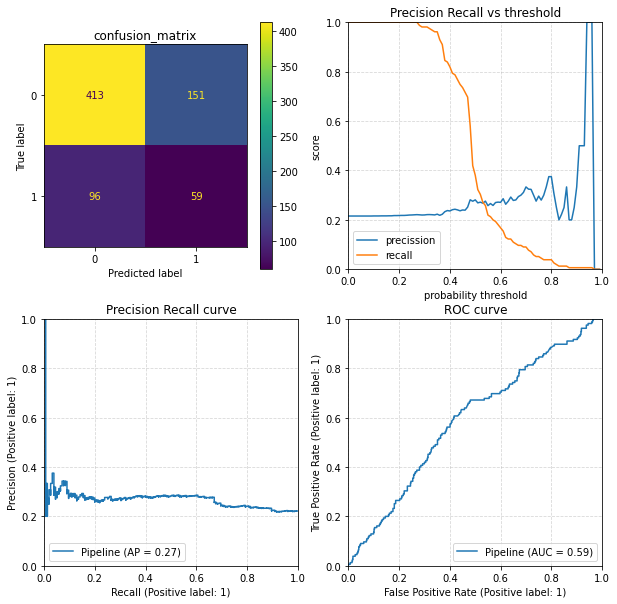

In [7]:
y_val_pred = linear_model_full.predict(x_val)

display(print(metrics.classification_report(y_val, y_val_pred)))

ax = plot_metric_curves(linear_model_full, x_val, y_val)

## Save model 

In [8]:
model_path = 'models'
if not os.path.exists(model_path):
    os.makedirs(model_path)

joblib.dump(linear_model, f'{model_path}/linear_model.job')

['models/linear_model.job']